linear_none: Epoch 100/3000, loss=0.237558
linear_none: Epoch 200/3000, loss=0.213528
linear_none: Epoch 300/3000, loss=0.219468
linear_none: Epoch 400/3000, loss=0.222284
linear_none: Epoch 500/3000, loss=0.220815
linear_none: Epoch 600/3000, loss=0.215884
linear_none: Epoch 700/3000, loss=0.209509
linear_none: Epoch 800/3000, loss=0.203392
linear_none: Epoch 900/3000, loss=0.212278
linear_none: Epoch 1000/3000, loss=0.199452
linear_none: Epoch 1100/3000, loss=0.213509
linear_none: Epoch 1200/3000, loss=0.210907
linear_none: Epoch 1300/3000, loss=0.206695
linear_none: Epoch 1400/3000, loss=0.205526
linear_none: Epoch 1500/3000, loss=0.212923
linear_none: Epoch 1600/3000, loss=0.213212
linear_none: Epoch 1700/3000, loss=0.202957
linear_none: Epoch 1800/3000, loss=0.204175
linear_none: Epoch 1900/3000, loss=0.206088
linear_none: Epoch 2000/3000, loss=0.200610
linear_none: Epoch 2100/3000, loss=0.202070
linear_none: Epoch 2200/3000, loss=0.197343
linear_none: Epoch 2300/3000, loss=0.1997

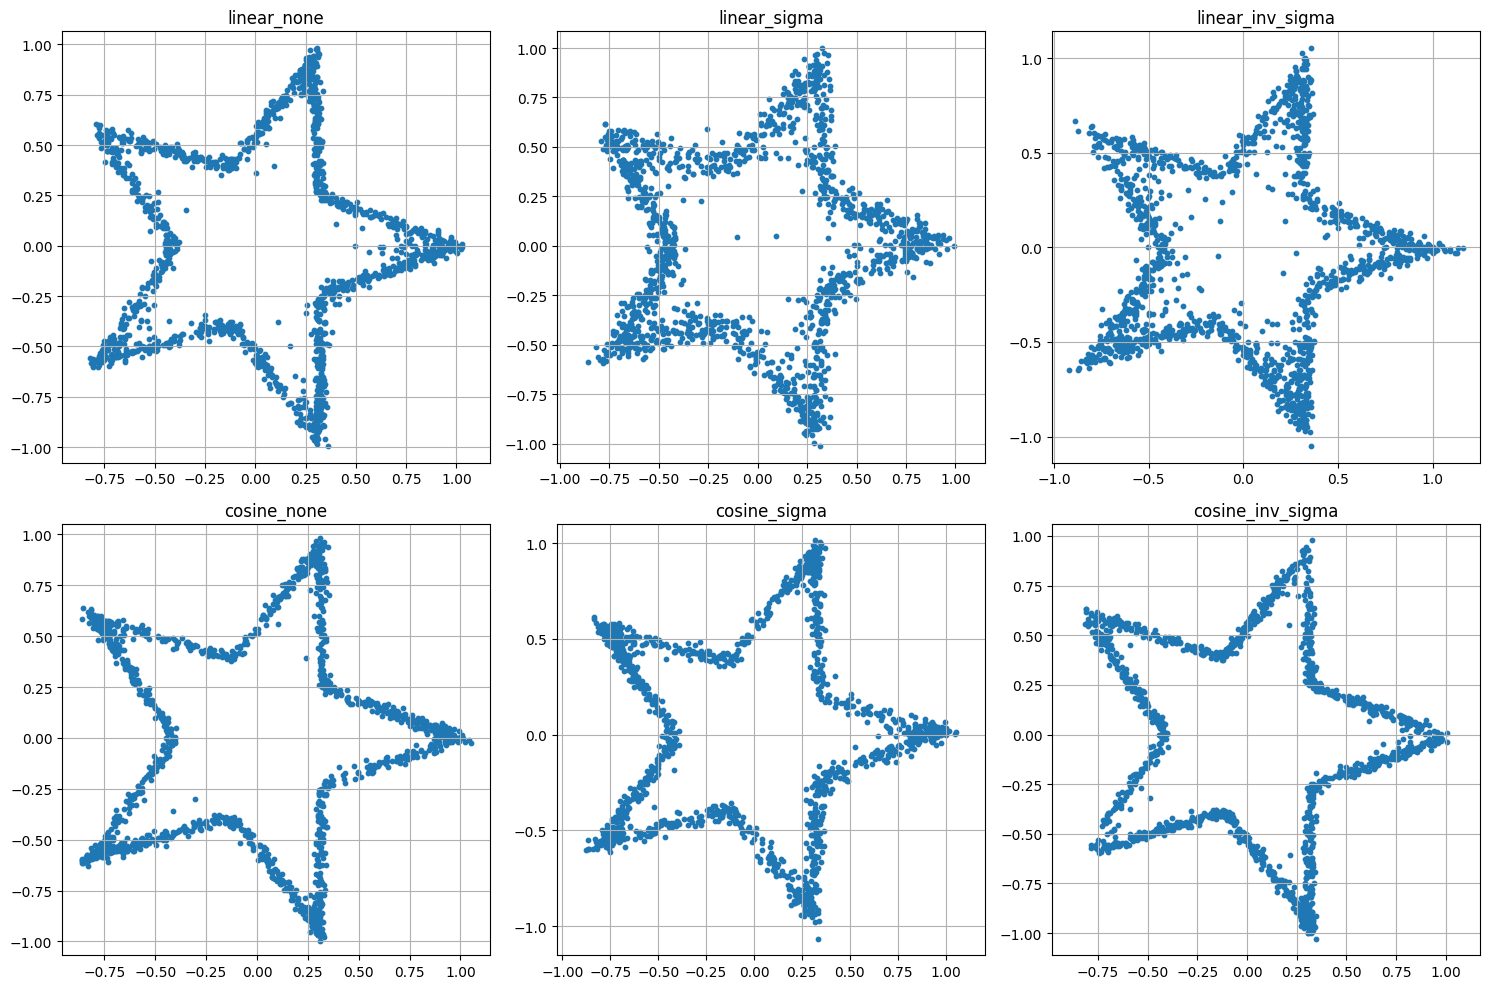

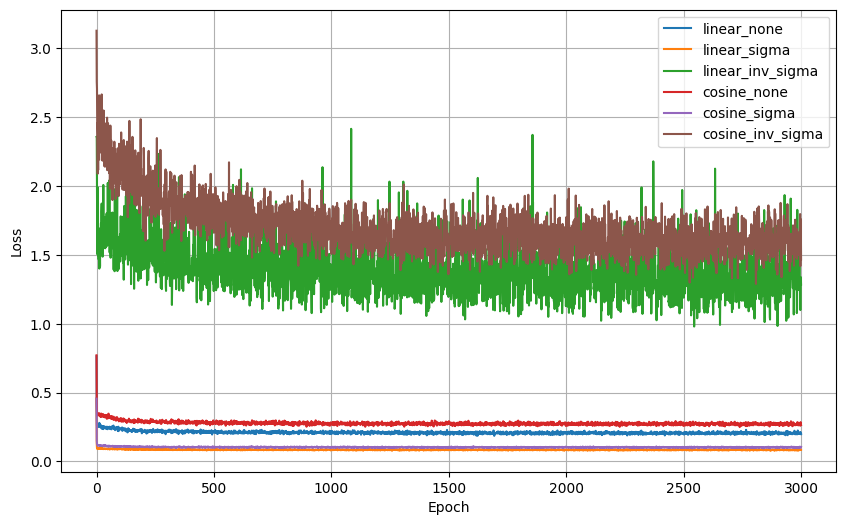

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def generate_star_5(n_total=5000, inner_r=0.4, outer_r=1.0):
    n_spikes = 5
    angle_step = np.pi / n_spikes
    verts = []
    for i in range(2 * n_spikes):
        angle = i * angle_step
        r = outer_r if (i % 2 == 0) else inner_r
        x = r * math.cos(angle)
        y = r * math.sin(angle)
        verts.append([x, y])
    verts.append(verts[0])
    verts = np.array(verts, dtype=np.float32)
    points = []
    n_edges = len(verts) - 1
    pts_per_edge = n_total // n_edges
    for i in range(n_edges):
        A = verts[i]
        B = verts[i + 1]
        for t in np.linspace(0, 1, pts_per_edge, endpoint=False):
            pt = (1 - t) * A + t * B
            points.append(pt)
    data = np.array(points, dtype=np.float32)
    maxabs = np.abs(data).max()
    if maxabs > 0:
        data /= maxabs
    return data

beta_min = 0.1
beta_max = 10.0

def beta_linear(t):
    return beta_min + (beta_max - beta_min) * t

def integral_beta_linear(t):
    return beta_min * t + 0.5 * (beta_max - beta_min) * (t ** 2)

def m_linear(t):
    if isinstance(t, float):
        return math.exp(-0.5 * (beta_min * t + 0.5 * (beta_max - beta_min) * t * t))
    else:
        return torch.exp(-0.5 * (beta_min * t + 0.5 * (beta_max - beta_min) * t * t))

def m_cosine(t):
    if isinstance(t, float):
        return math.cos(((t + 0.008) / 1.008) * (math.pi / 2))
    else:
        return torch.cos(((t + 0.008) / 1.008) * (math.pi / 2))

def get_alpha_sigma(t_tensor, schedule_type):
    if schedule_type == "linear":
        m_val = m_linear(t_tensor)
    elif schedule_type == "cosine":
        m_val = m_cosine(t_tensor)
    else:
        raise ValueError("Unknown schedule type")
    alpha = m_val
    sigma = torch.sqrt(1.0 - m_val**2)
    return alpha, sigma

def loss_weight(t, sigma, variant):
    if variant == "none":
        return torch.ones_like(t)
    elif variant == "sigma":
        return sigma
    elif variant == "inv_sigma":
        return 1.0 / torch.clamp(sigma, min=1e-4)
    else:
        raise ValueError("Unknown loss variant")

class ScoreModel(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(hidden_dim + 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        inp = torch.cat([x, t_emb], dim=1)
        return self.net(inp)

class Trainer:
    def __init__(self, epochs=3000, batch_size=256, lr=1e-3, num_steps_sampling=1000, schedule_type="linear", loss_variant="none", device=None):
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.num_steps_sampling = num_steps_sampling
        self.schedule_type = schedule_type
        self.loss_variant = loss_variant
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data_star = generate_star_5(n_total=5000, inner_r=0.4, outer_r=1.0)
        self.data_star = data_star
        data_star = torch.from_numpy(data_star)
        dataset = TensorDataset(data_star)
        self.loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.model = ScoreModel(hidden_dim=256).to(self.device)
        self.opt = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_history = []
    def train_epoch(self):
        self.model.train()
        total_loss = 0.0
        eps = 1e-5
        for (batch,) in self.loader:
            batch = batch.to(self.device)
            t_rand = (1 - 2 * eps) * torch.rand(batch.shape[0], 1, device=self.device) + eps
            alpha, sigma = get_alpha_sigma(t_rand, self.schedule_type)
            eps_data = torch.randn_like(batch)
            x_t = alpha * batch + sigma * eps_data
            self.opt.zero_grad()
            pred = self.model(x_t, t_rand)
            loss_elem = ((pred - eps_data) ** 2).mean(dim=1)
            weight = loss_weight(t_rand, sigma, self.loss_variant).squeeze()
            loss = (loss_elem * weight).mean()
            loss.backward()
            self.opt.step()
            total_loss += loss.item() * batch.size(0)
        return total_loss / len(self.loader.dataset)
    def train(self):
        for e in range(self.epochs):
            L = self.train_epoch()
            self.loss_history.append(L)
            if (e + 1) % 100 == 0:
                print(f"{self.schedule_type}_{self.loss_variant}: Epoch {e+1}/{self.epochs}, loss={L:.6f}")
    def sample(self, n_samples=1000):
        self.model.eval()
        x = torch.randn(n_samples, 2, device=self.device)
        dt = 1.0 / self.num_steps_sampling
        with torch.no_grad():
            for i in range(self.num_steps_sampling):
                t_cur = 1.0 - i * dt
                b_t = beta_linear(t_cur)
                t_tensor = torch.full((n_samples, 1), t_cur, device=self.device)
                _, sigma_t = get_alpha_sigma(t_tensor, self.schedule_type)
                sigma_t = torch.clamp(sigma_t, min=1e-4)
                eps_pred = self.model(x, t_tensor)
                drift = 0.5 * b_t * x - (b_t / sigma_t) * eps_pred
                noise = math.sqrt(b_t * dt) * torch.randn_like(x)
                x = x + drift * dt + noise
        return x.cpu().numpy()

def main():
    experiments = [
        {"schedule_type": "linear", "loss_variant": "none"},
        {"schedule_type": "linear", "loss_variant": "sigma"},
        {"schedule_type": "linear", "loss_variant": "inv_sigma"},
        {"schedule_type": "cosine", "loss_variant": "none"},
        {"schedule_type": "cosine", "loss_variant": "sigma"},
        {"schedule_type": "cosine", "loss_variant": "inv_sigma"}
    ]
    results = {}
    for exp in experiments:
        key = f"{exp['schedule_type']}_{exp['loss_variant']}"
        trainer = Trainer(epochs=3000, batch_size=256, lr=1e-3, num_steps_sampling=1000, schedule_type=exp['schedule_type'], loss_variant=exp['loss_variant'])
        trainer.train()
        samples = trainer.sample(n_samples=1500)
        results[key] = {"loss": trainer.loss_history, "samples": samples}
    fig1, axs1 = plt.subplots(2, 3, figsize=(15, 10))
    keys = list(results.keys())
    for i, key in enumerate(keys):
        ax = axs1[i // 3, i % 3]
        ax.scatter(results[key]["samples"][:, 0], results[key]["samples"][:, 1], s=10)
        ax.set_title(key)
        ax.axis("equal")
        ax.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 6))
    for key in keys:
        plt.plot(results[key]["loss"], label=key)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


# Выводы
**Графики и результаты**: Полученные результаты подтверждают, что линейное и косинусное расписания для параметра 𝛽(𝑡) приводят к различным характеристикам сгенерированных данных. Линейное расписание приводит к большему разбросу точек на графике, в то время как косинусное расписание даёт более сбалансированное распределение данных, ближе к центру.

**Потери (Losses)**: Потери для линейного расписания варьируются с небольшими колебаниями и достигают значения около 0.95, что свидетельствует о более трудном процессе обучения и нестабильности на некоторых этапах. Для косинусного расписания потери более стабильны и стабильнее снижаются, что указывает на более сбалансированное обучение.
